.ipynb folder for testing model collapse on two general machine learning models: random forest & linear regression. 

To start, there will be several tests of the machine learning models to try and maximize accuracy before the 

In [1]:
        
import random          

# using alexhusted's random forest project as reference for implementing random forest

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import SkLearn
from sklearn import tree, preprocessing
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
                

In [2]:
# dataset with pandas
url = "https://archive.ics.uci.edu/static/public/350/data.csv"
credit_data = pd.read_csv(url, sep=',')

In [3]:
# rename the columns, remove ID column
credit_data = credit_data.rename(columns={'X1':'LIMIT_BAL','X2':'SEX','X3':'EDUCATION','X4':'MARRIAGE','X5':'AGE','X6':'PAY_1','X7':'PAY_2',
                                          'X8':'PAY_3','X9':'PAY_4','X10':'PAY_5','X11':'PAY_6','X12':'BILL_AMT1','X13':'BILL_AMT2',
                                          'X14':'BILL_AMT3','X15':'BILL_AMT4','X16':'BILL_AMT5','X17':'BILL_AMT6','X18':'PAY_AMT1',
                                          'X19':'PAY_AMT2','X20':'PAY_AMT3','X21':'PAY_AMT4','X22':'PAY_AMT5','X23':'PAY_AMT6','Y':'DEFAULT'})
credit_data = credit_data.drop('ID', axis=1)


Run a correlation matrix to identify too highly-correlated variables to remove. This prevents overfitting in the model. 

<Axes: >

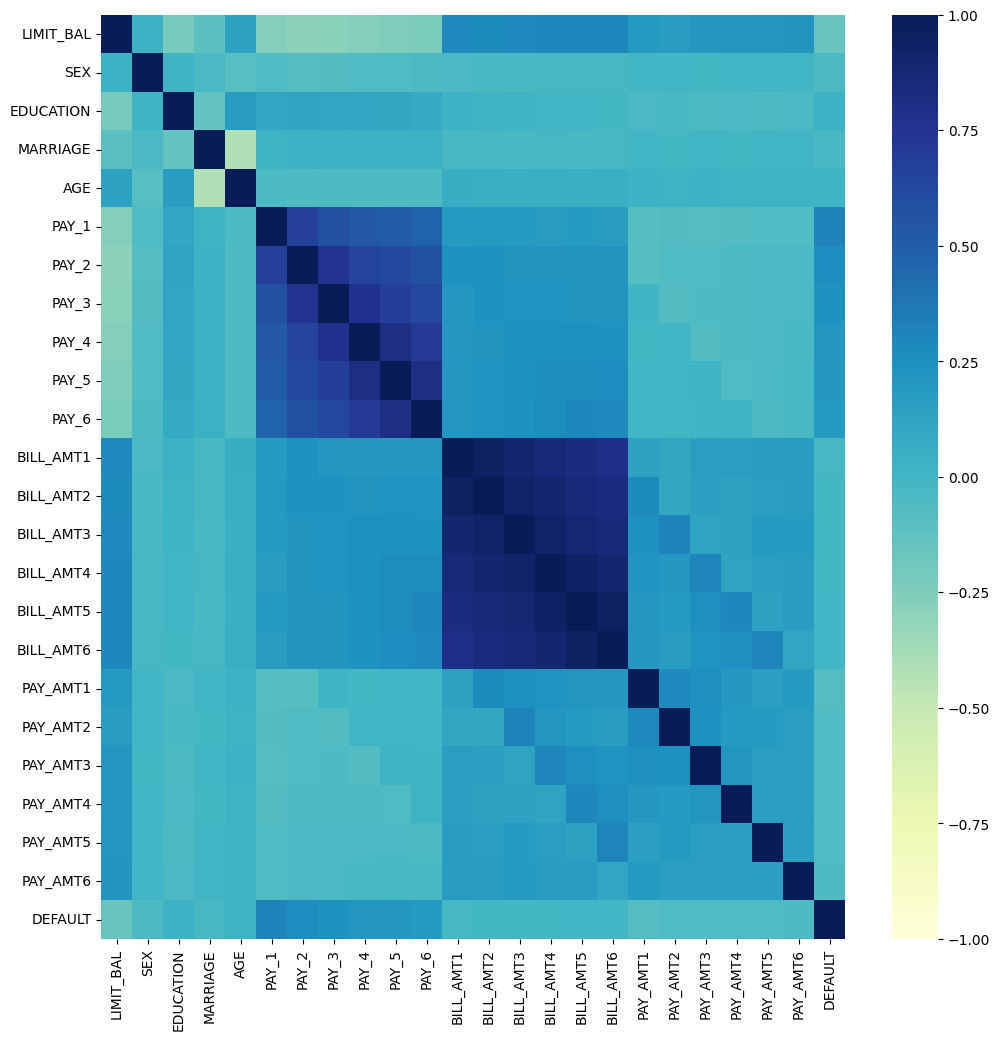

In [4]:
corr_matrix = credit_data.corr()
# Plot the new correlation matrix based upon the created dataframe 'corr_df'
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, cmap='YlGnBu', vmin=-1, vmax=1)

There aren't any strong correlations with the target variable DEFAULT, so there's no need to drop anything. 

# Random Forest Model

Create and Train the RF Model

In [5]:
# create datasets with and without 'quality'
Xa1 = credit_data.drop(['DEFAULT'], axis=1)
ya1 = credit_data['DEFAULT']

In [6]:
# train/test split on the data
# doing 50% split because of equal data in repeated generations
Xa1_train, Xa1_test, ya1_train, ya1_test = train_test_split(Xa1, ya1, test_size=0.5, random_state=321)

#confirm the data
print(Xa1_test)
print(ya1_test)
print(Xa1_train)
print(ya1_train)

       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
27218     200000    1          3         2   31      0      0      0     -2   
24972      50000    1          1         1   37      0      0      0     -2   
5666      400000    1          1         2   33      0      0      0     -2   
20346      60000    2          3         1   66      0      0      2      2   
26874     350000    1          3         1   37      0      0      0      0   
...          ...  ...        ...       ...  ...    ...    ...    ...    ...   
8901      250000    2          1         2   40     -1     -1     -1     -1   
8323       20000    1          2         1   39      2      2      2      2   
6453       60000    2          2         1   23      0      0      0      2   
7735       30000    2          1         2   28      0      0      0      0   
349        30000    2          2         2   26      0      0      0      0   

       PAY_5  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5 

Create/Run the Random Forest Model

In [7]:
# initialize rf model (sklearn)
rf_model = RandomForestClassifier(n_estimators=100)
# fit the model on the train data
rf_model.fit(Xa1_train, ya1_train)

RandomForestClassifier()

In [8]:
# Print the model score based upon the random forest classifier



y_pred = rf_model.predict(Xa1_test)
accuracy = accuracy_score(ya1_test, y_pred)
print(accuracy)

0.8176666666666667


In [9]:
cm = confusion_matrix(y_true=ya1_test, y_pred=y_pred)
print(cm)

[[11045   669]
 [ 2066  1220]]


Build a Synthetic Feature Space to generate synthetic feature data

In [10]:
def generate_synthetic_features(rf_model, num_samples, X_train):
    synthetic_samples = []
    feature_names = X_train.columns

    # Precompute min and max for each feature
    feature_min = X_train.min()
    feature_max = X_train.max()

    # Iterate until we have generated the required number of synthetic samples
    while len(synthetic_samples) < num_samples:
        # Choose a random tree from the Random Forest
        random_tree = random.choice(rf_model.estimators_)
        tree = random_tree.tree_
        
        # Create an empty synthetic sample with NaN values
        synthetic_sample = np.full(len(feature_names), np.nan)
        
        # Start from the root node and traverse until a leaf is reached
        node_id = 0  # Start at the root node
        
        while tree.children_left[node_id] != tree.children_right[node_id]:
            left_child = tree.children_left[node_id]
            right_child = tree.children_right[node_id]
            feature = tree.feature[node_id]
            threshold = tree.threshold[node_id]

            # Get number of samples going left and right
            n_node_samples = tree.n_node_samples[node_id]
            n_left = tree.n_node_samples[left_child]
            n_right = tree.n_node_samples[right_child]

            # Compute probabilities
            p_left = n_left / n_node_samples
            p_right = n_right / n_node_samples

            # Decide to go left or right based on probabilities
            if random.random() < p_left:
                # Go to the left child (value <= threshold)
                min_val = feature_min[feature_names[feature]]
                max_val = threshold
                node_id = left_child
            else:
                # Go to the right child (value > threshold)
                min_val = threshold
                max_val = feature_max[feature_names[feature]]
                node_id = right_child

            # Sample a value for the feature (if not already set)
            if np.isnan(synthetic_sample[feature]):
                synthetic_sample[feature] = random.uniform(min_val, max_val)
            
        # For features not set, assign random values within min and max
        for i in range(len(feature_names)):
            if np.isnan(synthetic_sample[i]):
                synthetic_sample[i] = random.uniform(feature_min[feature_names[i]], feature_max[feature_names[i]])

        # Append the generated sample to the list
        synthetic_samples.append(synthetic_sample)
    
    # Convert the list of synthetic samples to a DataFrame
    X_synthetic = pd.DataFrame(synthetic_samples, columns=feature_names)

    return X_synthetic

Run the generations with self-generated data

Iteration 1: Accuracy = 0.7819
Confusion Matrix:
[[11692    22]
 [ 3250    36]]

Iteration 2: Accuracy = 0.7809
Confusion Matrix:
[[11714     0]
 [ 3286     0]]

Iteration 3: Accuracy = 0.7809
Confusion Matrix:
[[11714     0]
 [ 3286     0]]

Iteration 4: Accuracy = 0.7809
Confusion Matrix:
[[11714     0]
 [ 3286     0]]

Iteration 5: Accuracy = 0.7809
Confusion Matrix:
[[11714     0]
 [ 3286     0]]

Iteration 6: Accuracy = 0.7809
Confusion Matrix:
[[11714     0]
 [ 3286     0]]

Iteration 7: Accuracy = 0.7809
Confusion Matrix:
[[11714     0]
 [ 3286     0]]

Iteration 8: Accuracy = 0.7809
Confusion Matrix:
[[11714     0]
 [ 3286     0]]

Iteration 9: Accuracy = 0.7809
Confusion Matrix:
[[11714     0]
 [ 3286     0]]

Iteration 10: Accuracy = 0.7809
Confusion Matrix:
[[11714     0]
 [ 3286     0]]

Iteration 11: Accuracy = 0.7809
Confusion Matrix:
[[11714     0]
 [ 3286     0]]

Iteration 12: Accuracy = 0.7809
Confusion Matrix:
[[11714     0]
 [ 3286     0]]

Iteration 13: Accuracy = 

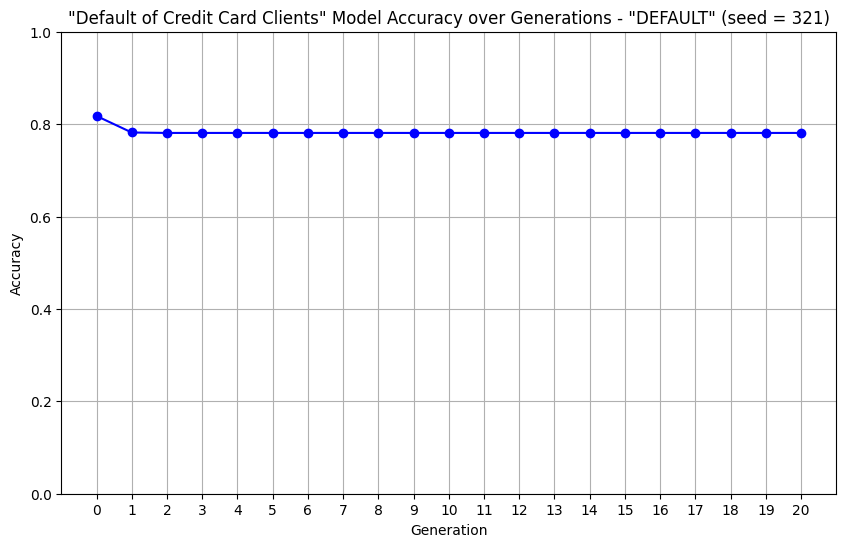

In [11]:
accuracies = []
accuracies.append(accuracy)
iterations = []
iterations.append(0)

X_synthetic = generate_synthetic_features(rf_model, 15000, Xa1_train)

for i in range(1, 21):
    # Step 1: Generate new synthetic features based on current training set
    X_synthetic = generate_synthetic_features(rf_model, 15000, X_synthetic)
    
    # Step 2: Use the current model to predict labels for the synthetic data
    y_synthetic = rf_model.predict(X_synthetic)
    
    # Step 4: Train a new Random Forest model on the synthetic dataset
    rf_model = RandomForestClassifier(n_estimators=100)
    rf_model.fit(X_synthetic, y_synthetic)

    # Step 5: Evaluate the new model on the original fixed test set
    y_test_pred = rf_model.predict(Xa1_test)
    accuracy = accuracy_score(ya1_test, y_test_pred)
    
    # Print iteration and accuracy
    print(f"Iteration {i}: Accuracy = {accuracy:.4f}")
    cm = confusion_matrix(y_true=ya1_test, y_pred=y_test_pred)
    print(f"Confusion Matrix:\n{cm}\n")
    
    # Append accuracy and iteration number to lists
    accuracies.append(accuracy)
    iterations.append(i)

# After the loop, plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(iterations, accuracies, marker='o', linestyle='-', color='b')
plt.title('"Default of Credit Card Clients" Model Accuracy over Generations - "DEFAULT" (seed = 321)')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.xticks(iterations)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [21]:
# Display the confusion matrix
y_pred = rf_model.fit(Xa1_train, ya1_train).predict(Xa1_test)
cm = confusion_matrix(y_true = ya1_test, y_pred = y_pred)
print(cm)

[[11047   667]
 [ 2054  1232]]


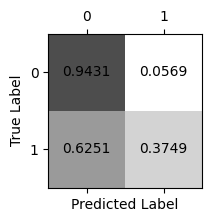

In [22]:
# Plot the Predicted Label vs. True Label accuracy matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig,ax = plt.subplots(figsize=(2,2))
ax.matshow(cmn, cmap=plt.cm.Greys, alpha=0.7)
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        ax.text(x=j, y=i, s=f'{cmn[i,j]:.4f}', va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

[[11714     0]
 [ 3286     0]]


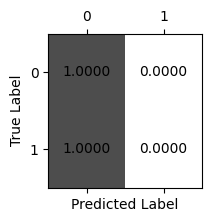

In [23]:
y_pred = rf_model.fit(X_synthetic, y_synthetic).predict(Xa1_test)
cm = confusion_matrix(y_true = ya1_test, y_pred = y_pred)
print(cm)

# Plot the Predicted Label vs. True Label accuracy matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig,ax = plt.subplots(figsize=(2,2))
ax.matshow(cmn, cmap=plt.cm.Greys, alpha=0.7)
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        ax.text(x=j, y=i, s=f'{cmn[i,j]:.4f}', va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()